In [1]:
from os.path import join
from os import listdir
import re
import cv2
from PIL import Image

from numpy import asarray,zeros,insert,uint8,unique,float32,fromiter
from matplotlib.pyplot import imshow as imshow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,GlobalAvgPool2D,Dropout
from tensorflow.keras import Input
from tensorflow.keras.applications import MobileNetV2,MobileNet,ResNet50V2,InceptionV3
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_inputM
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_inputM2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_inputR
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inputI
from sklearn.metrics import f1_score,confusion_matrix,multilabel_confusion_matrix
from seaborn import heatmap
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import random_brightness,random_shift,random_rotation,random_zoom
import random

In [2]:
path = join('images','images')
for im in listdir(path):
    if(im.find(".jpg") > 0):
        img = Image.open(join(path,im))
        img = img.resize((224,224))
        img.convert('RGB').save(join(path,'images2',im))

In [3]:
def labelDef(filename):
    checandoLabel = re.match('[a-z]{1}.+',filename)
    if(checandoLabel):
        return 0
    return 1    
    

In [4]:
def loadDatabase():
    path = join('images','images','images2')
    images = []
    labels = []
    i = 0
    for im in listdir(path):
        if(im.find(".jpg") > 0):
            images += [cv2.imread(join(path,im),cv2.IMREAD_COLOR)]
            labels += [labelDef(im)]
            i+=1
    return images,labels    

In [5]:
def buildModelMobileNet():
    input = Input(shape=(224,224,3))
    model = Sequential()
    model.add(MobileNet(include_top=False, input_tensor=input,pooling=max,alpha=1.0,dropout=0.2))
    model.trainable = False
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
    return model

In [8]:
def buildModelMobileNet():
    input = Input(shape=(224,224,3))

    base_model = MobileNet(include_top=False, input_tensor=input,pooling=max,alpha=1.0,dropout=0.2)
    base_model.trainable = False

    flatten = Flatten()
    dense = Dense(1,activation='sigmoid')
    
    model = Sequential([
        base_model,
        flatten,
        dense
    ])

    model.compile(loss='binary_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])
    return model

In [6]:
x,y = loadDatabase()
x= asarray(x,dtype=uint8)
x = preprocess_input(x)
y = asarray(y,dtype=uint8)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x = []
y  =[]

In [7]:
model = buildModelMobileNet()

M:\miniconda3\envs\tf_gpu\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [8]:
history = model.fit(x_train,y_train,validation_split=0.3,epochs=10,batch_size=10)

Train on 3465 samples, validate on 1486 samples
Epoch 1/10
3465/3465 [==============================] - 10s 3ms/sample - loss: 1.1714 - accuracy: 0.9019 - val_loss: 0.1588 - val_accuracy: 0.9818
Epoch 2/10
3465/3465 [==============================] - 6s 2ms/sample - loss: 0.5597 - accuracy: 0.9561 - val_loss: 0.3324 - val_accuracy: 0.9785
Epoch 3/10
3465/3465 [==============================] - 5s 2ms/sample - loss: 0.3559 - accuracy: 0.9657 - val_loss: 0.1706 - val_accuracy: 0.9838
Epoch 4/10
3465/3465 [==============================] - 5s 2ms/sample - loss: 0.2493 - accuracy: 0.9784 - val_loss: 0.2076 - val_accuracy: 0.9812
Epoch 5/10
3465/3465 [==============================] - 6s 2ms/sample - loss: 0.2220 - accuracy: 0.9815 - val_loss: 0.8952 - val_accuracy: 0.9448
Epoch 6/10
3465/3465 [==============================] - 6s 2ms/sample - loss: 0.1640 - accuracy: 0.9887 - val_loss: 1.3391 - val_accuracy: 0.9381
Epoch 7/10
3465/3465 [==============================] - 5s 2ms/sample - los

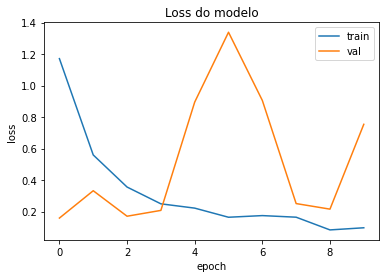

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss do modelo")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train', 'val'])
plt.show()    

In [10]:
y_pred = model.predict(x_test)


In [11]:
y_pred = asarray(y_pred,dtype=uint8)

In [12]:
f1 = f1_score(y_test,y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

0.9226464546142347


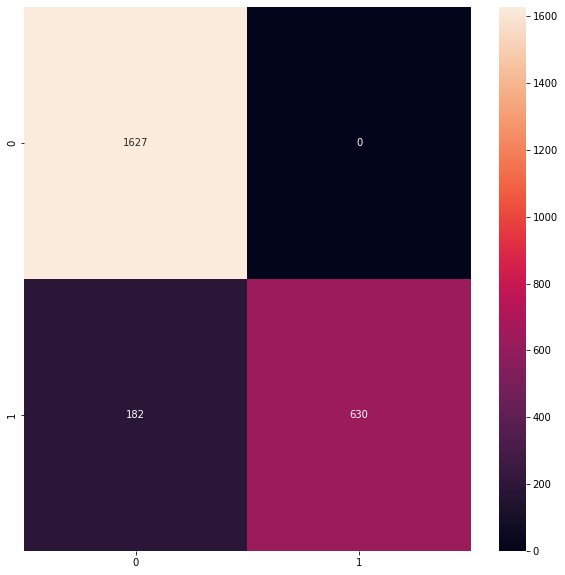

In [13]:
print(f1)
plt.figure(figsize=(10,10))
heatmap(cm, annot=True,fmt="d")
plt.show()

# Agora tentando classificar por raça e não só se é Dog ou Cat

In [2]:
def labelDefMultipleClasses(filename):
    list = re.findall('[^_][a-zA-Z]+[^_]',filename)
    label = ""
    for i in range(0,len(list)-1):
        label+=list[i]
    return label

In [3]:
def loadDatabaseMultipleClasses():
    path = join('images','images','images2')
    images = []
    labels = []
    i = 0
    for im in listdir(path):
        if(im.find(".jpg") > 0):
            images += [cv2.imread(join(path,im),cv2.IMREAD_COLOR)]
            labels += [labelDefMultipleClasses(im)]
            i+=1
    return images,labels    

In [4]:
def buildModelMobileNetMultipleClasses(classes_num):
    input = Input(shape=(224,224,3))
    model = Sequential()
    #model.add(MobileNet(include_top=False, input_tensor=input,pooling=max,alpha=0.75,dropout=0.2))
    #model.add(MobileNet(include_top=False,input_tensor=input))
    #model.add(MobileNetV2(include_top=False,input_tensor=input))
    #model.add(ResNet50V2(include_top=False,input_tensor=input))
    model.add(InceptionV3(include_top=False,input_tensor=input))
    model.trainable = False
    model.add(GlobalAvgPool2D())
    model.add(Dense(50))
    model.add(Dropout(0.2))
    model.add(Dense(classes_num,activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [5]:
def preProcessLabels(labels):
    le = preprocessing.LabelEncoder()
    labels = le.fit_transform(labels)
    num_labels = len(le.classes_)
    labels = to_categorical(labels,num_classes=num_labels)
    return labels, num_labels

In [6]:
def dataAugmentation(input):
    #random.seed()
    #i = random.randint(1,3)
    i = 1
    if(i ==1):
        input = random_rotation(input,30,channel_axis=2)
    elif(i == 2):
        input = random_shift(input,0.2,0.3)
    else:
        input = random_zoom(input,[0.7,0.5],row_axis=0, col_axis=1,channel_axis=2)
    return input

Augmentations | F1Score
--------------|---------
nenhuma | 75
rotation | 78
shift | 71
zoom | 70
rotation + shift | 73
rotation + zoom | 71
shift+ zoom | 71
rotation + shift + zoom | 67
rotation or shift or zoom | 75

In [7]:
x,y = loadDatabaseMultipleClasses()
x= asarray(x,dtype=float32)
y, num_labels = preProcessLabels(y)
y = asarray(y,dtype=float32)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x = []
y  =[]

In [8]:
for i in range(x_train.shape[0]):
    x_train[i] = dataAugmentation(x_train[i])
x_train = preprocess_inputI(x_train)
x_test = preprocess_inputI(x_test)    

In [9]:
z, a = unique(y,return_counts=True)

In [10]:
modelMultipleClasses = buildModelMobileNetMultipleClasses(num_labels)

In [11]:
historyMultipleClasses = modelMultipleClasses.fit(x_train,y_train,validation_split=0.3,epochs=10,batch_size=10)

Train on 3465 samples, validate on 1486 samples
Epoch 1/10
3465/3465 [==============================] - 22s 6ms/sample - loss: 2.5475 - accuracy: 0.3212 - val_loss: 1.2082 - val_accuracy: 0.6649
Epoch 2/10
3465/3465 [==============================] - 14s 4ms/sample - loss: 1.7278 - accuracy: 0.4984 - val_loss: 1.2582 - val_accuracy: 0.6945
Epoch 3/10
3465/3465 [==============================] - 14s 4ms/sample - loss: 1.4631 - accuracy: 0.5657 - val_loss: 1.1144 - val_accuracy: 0.7254
Epoch 4/10
3465/3465 [==============================] - 14s 4ms/sample - loss: 1.3527 - accuracy: 0.5931 - val_loss: 0.9805 - val_accuracy: 0.7598
Epoch 5/10
3465/3465 [==============================] - 14s 4ms/sample - loss: 1.2571 - accuracy: 0.6095 - val_loss: 1.1557 - val_accuracy: 0.7369
Epoch 6/10
3465/3465 [==============================] - 13s 4ms/sample - loss: 1.2005 - accuracy: 0.6335 - val_loss: 1.1640 - val_accuracy: 0.7342
Epoch 7/10
3465/3465 [==============================] - 14s 4ms/sample

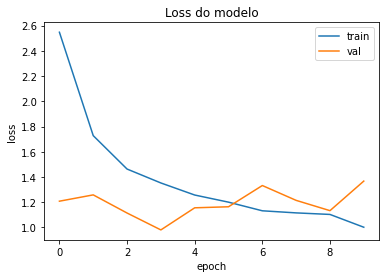

In [12]:
plt.plot(historyMultipleClasses.history['loss'])
plt.plot(historyMultipleClasses.history['val_loss'])
plt.title("Loss do modelo")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(['train', 'val'])
plt.show() 

In [13]:
y_pred = modelMultipleClasses.predict(x_test)

In [14]:
y_pred = asarray(y_pred,dtype=float32)

In [15]:
f1 = f1_score(y_test.argmax(1),y_pred.argmax(1), average='weighted')
cm = confusion_matrix(y_test.argmax(1), y_pred.argmax(1))

0.7403874603853813


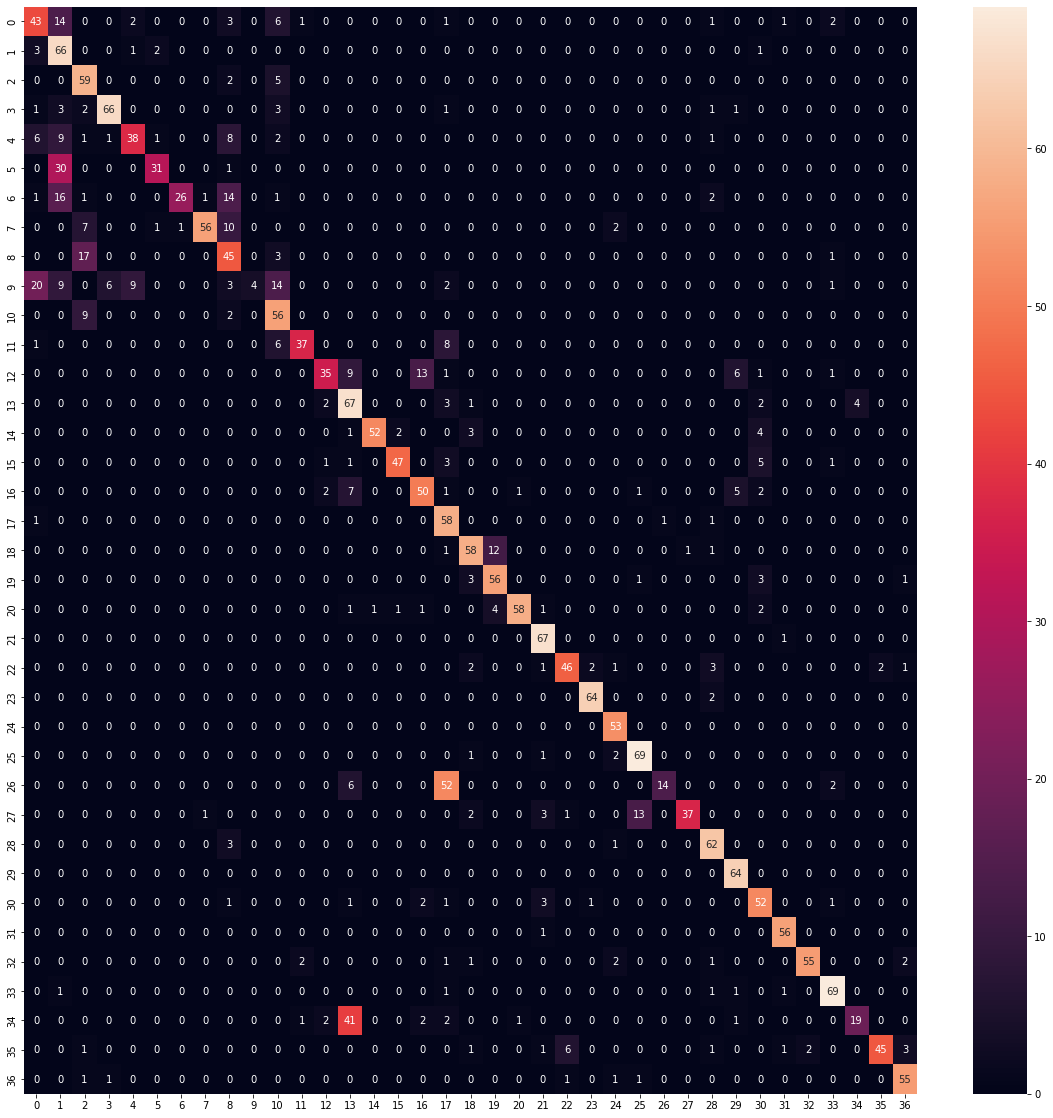

In [16]:
print(f1)
plt.figure(figsize=(20,20))
heatmap(cm, annot=True,fmt="d")
plt.show()

 Arquitetura | F1Score | Acuracia Treino | Acuracia Validação
------ | --------- | ------ | --------
MobileNet | 80 | 79 | 76 
MobileNetV2 | 79 | 77 | 76 
ResNet50V2 | 79 | 83 | 78 
InceptionV3 | 76 | 68 | 76 